# Injuries and EDA
The notebook is named 'EDA,' but it also will fetch the injury report from the api and filter injured players from the dataset. We also will have the option to manually remove players is their injury status is uncertain. The mins_proj and mins_share variables will be adjusted to account for the removed players.<br>

Then, finally, we will get summary statistics and histograms to check if our data makes sense.<br>

**If we need to adjust player availability, like putting a player back in the list who we took out before, we have to run this notebook again from the top and then run predictions.**

In [246]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import requests
import sqlite3
import re
import matplotlib.pyplot as plt
import pickle


# Get the parent directory where config.py is located
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

API_KEY = None
API_HOST = None

In [247]:
from config import API_KEY, API_HOST

headers = {
    "x-rapidapi-key": API_KEY,
    "x-rapidapi-host": API_HOST
}

In [248]:
site = input("Are you playing FanDuel or DraftKings?").lower()
if site == 'fanduel':
    site = 'FD'
else:
    site = 'DK'

Are you playing FanDuel or DraftKings? fanduel


In [249]:
today = (datetime.now()).strftime('%Y%m%d')

In [250]:
main_df = pd.read_csv('ready_for_injuries.csv')

In [251]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Brook Lopez,20250304_MIL@ATL,28006619932,17,MIL,ATL,10.533333,2.000000,1.733333,5.000000,...,30.866667,22.977667,6100,2025-03-04,C,False,False,False,False,True
1,Dejounte Murray,20250304_NO@LAL,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.400437,3500,2025-03-04,PG,True,False,False,False,False
2,Shake Milton,20250304_NO@LAL,28008397499,14,LAL,ORL,2.266667,1.333333,0.266667,1.066667,...,10.200000,7.079237,3600,2025-03-04,SG,True,False,False,False,False
3,Lonnie Walker IV,20250304_PHI@MIN,28018646789,23,PHI,HOU,6.933333,1.133333,0.933333,2.266667,...,16.000000,10.274706,3900,2025-03-04,SG,False,False,True,False,False
4,Steven Adams,20250304_HOU@IND,28018735349,11,HOU,TOR,4.466667,1.333333,0.000000,2.000000,...,15.733333,10.103203,4200,2025-03-04,C,False,False,False,False,True


In [252]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longName    315 non-null    object 
 1   game_id     315 non-null    object 
 2   player_id   315 non-null    int64  
 3   team_id     315 non-null    int64  
 4   team        315 non-null    object 
 5   teamAbv     315 non-null    object 
 6   fga         315 non-null    float64
 7   ast         315 non-null    float64
 8   tptfgm      315 non-null    float64
 9   fgm         315 non-null    float64
 10  fta         315 non-null    float64
 11  tptfga      315 non-null    float64
 12  OffReb      315 non-null    float64
 13  ftm         315 non-null    float64
 14  blk         315 non-null    float64
 15  DefReb      315 non-null    float64
 16  plusMinus   315 non-null    float64
 17  stl         315 non-null    float64
 18  pts         315 non-null    float64
 19  fouls       315 non-null    f

In [253]:
main_df[main_df['team'] == 'DAL'][['longName', 'mins_proj', 'mins_share']]

,longName,mins_proj,mins_share


In [254]:
#Changing player_id to string
main_df["player_id"] = main_df["player_id"].astype(str)

In [255]:
main_df['player_id'].nunique()

315

In [256]:
main_df['game_id'].unique()

array(['20250304_MIL@ATL', '20250304_NO@LAL', '20250304_PHI@MIN',
       '20250304_HOU@IND', '20250304_TOR@ORL', '20250304_GS@NY',
       '20250304_BKN@SA', '20250304_LAC@PHO', '20250304_CLE@CHI'],
      dtype=object)

In [257]:
#Remove teams that aren't in slate
#There's nothing programmatic about this. We just check the full NBA schedule against the FD or DK slate we're playing.
teams_to_remove = []
remove_teams = int(input("How many teams do you want to remove from the slate?"))
for i in range(0, remove_teams):
    teams_to_remove.append(input("Remove team."))

How many teams do you want to remove from the slate? 0


In [258]:
main_df = main_df[~main_df['team'].isin(teams_to_remove)]

In [259]:
player_ids = list(main_df['player_id'])

In [260]:
main_df['team'].unique()

array(['MIL', 'NO', 'LAL', 'PHI', 'HOU', 'TOR', 'GS', 'BKN', 'PHO', 'LAC',
       'ORL', 'IND', 'SA', 'NY', 'CLE', 'MIN', 'ATL', 'CHI'], dtype=object)

# Getting injury reports
We call the API to get injury information and availability status of every player in the current day's slate.

In [261]:
col_heads = ['name', 'player_id', 'injury', 'inj_date', 'status', 'return_date', 'last_game']
rows = []
for id in player_ids:
    
    url = f"https://tank01-fantasy-stats.p.rapidapi.com/getNBAPlayerInfo?playerID={id}"
        
    headers = {
        "x-rapidapi-key": "3103a75392msh7bce7c32fde122cp134393jsn4d42ed6d08a8",
        "x-rapidapi-host": "tank01-fantasy-stats.p.rapidapi.com"
    }
    
    response = requests.get(url, headers=headers)
    result = response.json()
    
    if 'body' in result and result['body']:  
        injury_data = result['body'].get('injury', {})
        if any(value != '' for value in injury_data.values()):  # Check if injury dict has data
            rows.append([
                result['body']['longName'],
                result['body']['playerID'],
                injury_data.get('description', ''),
                injury_data.get('injDate', ''),
                injury_data.get('designation', ''),
                injury_data.get('injReturnDate', ''),
                result['body'].get('lastGamePlayed', '')
            ])

injury_df = pd.DataFrame(rows, columns = col_heads)

In [262]:
injury_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Dejounte Murray,28008317499,Jan 31: Shams Charania of ESPNMurray suffered ...,,Out,20251001,20250131_BOS@NO
1,Steven Adams,28018735349,,20240805,,,20250301_SAC@HOU
2,Garrett Temple,28026396452,Mar 3: Temple (personal) will not play Tuesday...,,Out,20250307,20250131_CHI@TOR
3,Kyle Lowry,28036327222,Mar 4: Lowry (hip) has been ruled out for Tues...,,Out,20250306,20250209_PHI@MIL
4,Gary Payton II,28038983399,Mar 4: Payton (nose) will not play Tuesday aga...,,Out,20250306,20250303_GS@CHA
...,...,...,...,...,...,...,...
103,Gradey Dick,949147271869,Mar 4: The Raptors announced Tuesday that Dick...,20240805,Out,20250328,20250302_TOR@ORL
104,Day'Ron Sharpe,94924235527,,20240805,,,20250301_BKN@DET
105,Jared McCain,949340777989,Jan 9: McCain was reviewed Thursday by the sur...,,Out,20251001,20241213_IND@PHI
106,Jonathan Mogbo,949842011869,,20240805,,,20250302_TOR@ORL


In [263]:
len(injury_df)

108

In [264]:
#Filtering injury_df for players who are out.
out_df = injury_df[injury_df['status'] == 'Out']

In [265]:
#We need an extra safeguard here because we saw one day that players were listed as out 
#even though in the injury report it said they were questionable or probable
#This takes those players out of the out_df
out_df = out_df[~(out_df['injury'].str.lower().str.contains('questionable') | out_df['injury'].str.lower().str.contains('probable'))]

In [266]:
out_players = list(out_df['player_id'])

In [267]:
#Starting a dataframe of players who aren't playing and can't be used in lineups
removed_df = main_df[main_df['player_id'].isin(out_players)]

In [268]:
#Taking those players out of main_df
main_df = main_df[~main_df['player_id'].isin(out_players)]

In [269]:
removed_df

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
1,Dejounte Murray,20250304_NO@LAL,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.400437,3500,2025-03-04,PG,True,False,False,False,False
6,Garrett Temple,20250304_TOR@ORL,28026396452,28,TOR,CHI,0.866667,0.600000,0.066667,0.133333,...,3.800000,2.810354,3500,2025-03-04,SF,False,False,True,False,False
7,Kyle Lowry,20250304_PHI@MIN,28036327222,23,PHI,MIN,2.866667,2.933333,0.666667,0.933333,...,16.266667,10.445951,3700,2025-03-04,PG,True,False,False,False,False
9,Gary Payton II,20250304_GS@NY,28038983399,10,GS,IND,5.133333,1.466667,0.466667,2.933333,...,13.933333,11.134295,4200,2025-03-04,PG,False,True,False,False,False
24,Maxi Kleber,20250304_NO@LAL,28148908169,14,LAL,IND,3.600000,2.066667,0.533333,1.333333,...,20.266667,14.065934,3500,2025-03-04,C,False,False,False,True,False
27,Derrick Jones Jr.,20250304_LAC@PHO,28158545399,13,LAC,NY,7.933333,0.866667,0.866667,4.066667,...,26.000000,18.401393,4400,2025-03-04,SF,False,False,True,True,False
44,Eric Gordon,20250304_PHI@MIN,28246619932,23,PHI,MIN,6.266667,2.466667,2.266667,2.933333,...,24.333333,15.626115,3700,2025-03-04,SF,False,True,False,False,False
46,Nikola Vucevic,20250304_CLE@CHI,28268405032,5,CHI,LAC,13.600000,3.466667,1.200000,6.066667,...,31.733333,24.212367,7600,2025-03-04,C,False,False,False,False,True
50,Austin Reaves,20250304_NO@LAL,28268636399,14,LAL,OKC,13.333333,5.733333,2.466667,6.000000,...,32.733333,22.718334,7700,2025-03-04,SG,False,True,True,False,False
66,Norman Powell,20250304_LAC@PHO,28388721482,13,LAC,DET,17.066667,2.066667,2.600000,8.466667,...,33.933333,24.016177,7400,2025-03-04,SG,False,True,True,False,False


In [270]:
len(main_df)

270

In [271]:
out_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Dejounte Murray,28008317499,Jan 31: Shams Charania of ESPNMurray suffered ...,,Out,20251001,20250131_BOS@NO
2,Garrett Temple,28026396452,Mar 3: Temple (personal) will not play Tuesday...,,Out,20250307,20250131_CHI@TOR
3,Kyle Lowry,28036327222,Mar 4: Lowry (hip) has been ruled out for Tues...,,Out,20250306,20250209_PHI@MIL
4,Gary Payton II,28038983399,Mar 4: Payton (nose) will not play Tuesday aga...,,Out,20250306,20250303_GS@CHA
9,Maxi Kleber,28148908169,Feb 4: Kleber will have his surgically repaire...,,Out,20250411,20250125_BOS@DAL
11,Derrick Jones Jr.,28158545399,Mar 3: Jones (groin) is out for Tuesday's game...,,Out,20250305,20250228_LAC@LAL
16,Eric Gordon,28246619932,Feb 27: The 76ers announced Thursday that Gord...,,Out,20251001,20250209_PHI@MIL
17,Nikola Vucevic,28268405032,Mar 2: Vucevic (calf) said that he's hopeful t...,,Out,20250306,20250222_PHO@CHI
20,Austin Reaves,28268636399,Mar 4: Reaves (calf) will not play Tuesday aga...,,Out,20250306,20250228_LAC@LAL
26,Norman Powell,28388721482,Mar 3: Powell (hamstring) has been ruled out f...,,Out,20250305,20250302_LAC@LAL


In [272]:
#Starting a game-time-decision dataframe
gtd_df = injury_df[(injury_df['status'] == 'Day-To-Day') | (injury_df['injury'].str.lower().str.contains("probable", na=False)) | \
(injury_df['injury'].str.lower().str.contains("questionable", na=False))].reset_index(drop=True)

In [273]:
len(gtd_df)

21

In [274]:
gtd_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Stephen Curry,28046691632,Mar 4: Curry is questionable for Tuesday's gam...,,Day-To-Day,20250304,20250303_GS@CHA
1,Jock Landale,28108169129,Mar 4: Landale is questionable for Tuesday's g...,,Day-To-Day,20250304,20250303_HOU@OKC
2,Giannis Antetokounmpo,28118035349,Mar 3: Antetokounmpo is probable for Tuesday's...,,Day-To-Day,20250304,20250301_MIL@DAL
3,Ethan Thompson,28208889869,Mar 3: Thompson has agreed to a two-way deal w...,,Day-To-Day,20250305,
4,Paul George,28268421152,Mar 4: George (groin) is questionable for Tues...,,Day-To-Day,20250304,20250301_GS@PHI
5,Karl-Anthony Towns,28278119129,Mar 3: Towns (personal) is listed as questiona...,,Day-To-Day,20250304,20250302_NY@MIA
6,Daeqwon Plowden,28318649869,Mar 2: Plowden didn't play in Sunday's 126-108...,,Day-To-Day,20250306,20250125_TOR@ATL
7,Lonzo Ball,28368516399,Mar 3: Ball is questionable for Tuesday's game...,20240805,Day-To-Day,20250304,20250228_TOR@CHI
8,Kyle Kuzma,28398169069,Mar 4: Kuzma (ankle) has been listed as questi...,20240805,Day-To-Day,20250304,20250301_MIL@DAL
9,Luka Doncic,28398804489,Mar 4: Doncic (knee) has been listed as probab...,,Day-To-Day,20250304,20250302_LAC@LAL


In [275]:
#Saving the game-time decision dataframe to a CSV
#So that we can use it to take a player out of the dataset or put one back in at the last minute
gtd_df.to_csv('game_time_decisions.csv', index = False)

In [276]:
def get_full_report(player_idx_list):
    for player in player_idx_list:
        print(gtd_df.iloc[player, 2])

In [277]:
view_reports = input("Do you want to see any full injury reports?").lower()
player_idx_list = []
while view_reports == 'y':
    player_idx_list.append(int(input("Type the index number of the player to see his full injury report: ")))
    view_reports = input("Do you want to see any more injury reports?").lower()

get_full_report(player_idx_list)

Do you want to see any full injury reports? n


In [278]:
## Here, we make our judgment based on the injury reports, and decide whether or not to filter players out of the lineup
remove_dtd_list = []
remove_dtd = int(input("How many players do you want to remove from the player list?"))
for i in range(remove_dtd):
    player_to_remove = int(input("Enter the index number of the player to remove:"))
    remove_dtd_list.append(gtd_df.iloc[player_to_remove, 1])
    

How many players do you want to remove from the player list? 12
Enter the index number of the player to remove: 1
Enter the index number of the player to remove: 3
Enter the index number of the player to remove: 4
Enter the index number of the player to remove: 5
Enter the index number of the player to remove: 6
Enter the index number of the player to remove: 7
Enter the index number of the player to remove: 11
Enter the index number of the player to remove: 14
Enter the index number of the player to remove: 16
Enter the index number of the player to remove: 17
Enter the index number of the player to remove: 18
Enter the index number of the player to remove: 20


In [279]:
#This still leaves suspended players
remove_more = int(input("How many more players do you want to remove?"))

for i in range(remove_more):
    player_to_remove = input("Type player's name: ")
    player_ids = main_df.loc[main_df['longName'] == player_to_remove, 'player_id'].tolist()  # Convert to list
    
    remove_dtd_list.extend(player_ids)  # Add all matching player IDs to the list


How many more players do you want to remove? 0


In [280]:
print(remove_dtd_list)

['28108169129', '28208889869', '28268421152', '28278119129', '28318649869', '28368516399', '28598696399', '28768759882', '941649430339', '94354710482', '94544429047', '94744479027']


In [281]:
#Saving main_df in current state for last-minute changes at crunch time
# main_df.to_csv('ready_for_crunch.csv', index = False)

In [282]:
# crunch_time = input("Are you making crunch time changes?").lower()

In [283]:
# if crunch_time == 'y':
#     crunch_remove = []
#     crunch_add = []
#     main_df = pd.read_csv('ready_for_crunch.csv')
#     remove_num = int(input("How many players are you removing?"))
#     for i in range(remove_num):
#         player_to_remove = int(input("Enter the index number of the player to remove:"))
#         crunch_remove_list.append(gtd_df.iloc[player_to_remove, 1])
        
        

# Bringing in site template
We also need to bring in the site template here because there might be some players who have been out all season who might not show up on the api injury report. This is where we use fuzzy matching to match the names as they're written on the api with the names as they're written on the site.<br>

We thought we could get away without name matching until we reached the point where we load the lineups into the site templates. But it turns out we need to do it here. Hopefully this simplifies the notebook where we load the lineups into CSVs.<br>

We use player_ids to remove rows from main_df based an api injury reports. In most cases we figure filtering out the matched names is just a way to catch anyone who's fallen through the cracks.

In [284]:
import_template = input('Are you bringing in a site template?').lower()

if import_template == 'y':
    #This is the CSV downloaded from the site
    site_df = pd.read_csv(f"{site}_Template_{today}.csv")
    #The names as they're written on the site template
    if site == 'FD':
        template_names = list(site_df['Nickname'])
    else:
        template_names = list(site_df['Name'])
    #The names as they're written in the linups
    lineup_names = list(main_df['longName'].unique())
    print(f"Length template names: {len(template_names)}, Length lineup names: {len(lineup_names)}")
    template_set = set(template_names)
    lineup_set = set(lineup_names)
    #Get names in lineups that aren't on template
    lineup_names_not_on_template = lineup_set.difference(template_set)
    lineup_names_not_on_template

Are you bringing in a site template? y


Length template names: 315, Length lineup names: 270


In [285]:
# #The names as they're written on the site template
# if site == 'FD':
#     template_names = list(site_df['Nickname'])
# else:
#     template_names = list(site_df['Name'])

In [286]:
#The names as they're written in the linups
# lineup_names = list(main_df['longName'].unique())

In [287]:
#This function takes the unmatched lineup name and looks for matchins in the template
def fuzzy_match(name, dk_names):
    match, score, _ = process.extractOne(name, dk_names, scorer=fuzz.token_sort_ratio)
    return match if score >= SIMILARITY_THRESHOLD else None

In [288]:
if import_template == 'y':
    template_list = list(template_set)
    lineup_list = list(lineup_set)
    lineup_not_on_template = list(lineup_names_not_on_template)
    #Fuzzy matching starts here
    from rapidfuzz import process, fuzz
    SIMILARITY_THRESHOLD = 70
    matches_on_template = [fuzzy_match(x, template_list) for x in lineup_not_on_template]
    print(f"Matches on template: {matches_on_template}")
    #Making a dictionary
    names_to_change = dict(zip(lineup_not_on_template, matches_on_template))
    print(f"Names to change: {names_to_change}")
    #Add names by hand if the dictionary isn't full
    vals_to_add = int(input("How many values do you want to add to the dictionary?"))
    for i in range(vals_to_add):
        dict_key = input("Enter the name of the player with the empty value.")
        dict_value = input("Enter site name.")
        names_to_change[dict_key] = dict_value
    main_df['longName'] = main_df['longName'].replace(names_to_change)
    out_template_names = []
    if site == 'FD':
        out_template = site_df[site_df['Injury Indicator'] == 'O']
        out_template_names = list(out_template['Nickname'])
    if out_template_names:
        print(out_template_names)

Matches on template: ['David Duke', 'Keion Brooks', None, 'Dominick Barlow', 'Nic Claxton', 'Craig Porter', 'TyTy Washington', 'Kelly Oubre', 'Gary Trent', 'A.J. Lawson', 'Lonnie Walker', 'Patrick Baldwin', 'Wendell Carter', None, 'Trey Murphy', 'Andre Jackson', 'Kevin Knox', 'Brandon Boston', 'Kevin McCullar']
Names to change: {'David Duke Jr.': 'David Duke', 'Keion Brooks Jr.': 'Keion Brooks', 'Jamaree Bouyea': None, 'Dom Barlow': 'Dominick Barlow', 'Nicolas Claxton': 'Nic Claxton', 'Craig Porter Jr.': 'Craig Porter', 'TyTy Washington Jr.': 'TyTy Washington', 'Kelly Oubre Jr.': 'Kelly Oubre', 'Gary Trent Jr.': 'Gary Trent', 'AJ Lawson': 'A.J. Lawson', 'Lonnie Walker IV': 'Lonnie Walker', 'Patrick Baldwin Jr.': 'Patrick Baldwin', 'Wendell Carter Jr.': 'Wendell Carter', 'MarJon Beauchamp': None, 'Trey Murphy III': 'Trey Murphy', 'Andre Jackson Jr.': 'Andre Jackson', 'Kevin Knox II': 'Kevin Knox', 'Brandon Boston Jr.': 'Brandon Boston', 'Kevin McCullar Jr.': 'Kevin McCullar'}


How many values do you want to add to the dictionary? 1
Enter the name of the player with the empty value. Jamaree Bouyea
Enter site name. Jamaree Bouyea


['Tyrese Maxey', 'Evan Mobley', 'Nikola Vucevic', 'Norman Powell', 'Fred VanVleet', 'Brandon Ingram', 'Rudy Gobert', 'Jonathan Kuminga', 'Ben Simmons', 'Bobby Portis', 'Rui Hachimura', 'Gradey Dick', 'Jalen Suggs', 'Derrick Jones', 'Gary Payton', 'Charles Bassey', 'Ochai Agbaji', 'Noah Clowney', 'Patrick Williams', 'Jordan Goodwin', 'Kyle Lowry', 'Eric Gordon', 'Pat Connaughton', 'Larry Nance', 'Kobe Bufkin', 'Ariel Hukporti', 'Ulrich Chomche', 'Riley Minix', 'Dejounte Murray', 'Isaiah Jackson', 'Vit Krejci', 'Jalen Johnson', 'Herbert Jones', 'Ayo Dosunmu', 'Maxi Kleber', "De'Anthony Melton", 'Kendall Brown', 'Moritz Wagner', 'Cody Martin', 'Pete Nance', 'Garrett Temple', 'Jamison Battle', 'Jared McCain', 'Joel Embiid', 'Victor Wembanyama']


In [289]:
out_template_names_set = set(out_template_names)
removed_set = set(list(removed_df['longName']))

In [290]:
removed_set

{'Ariel Hukporti',
 'Austin Reaves',
 'Ayo Dosunmu',
 'Ben Simmons',
 'Bennedict Mathurin',
 'Brandon Ingram',
 'Charles Bassey',
 'Cody Martin',
 'Dejounte Murray',
 'Derrick Jones Jr.',
 'Eric Gordon',
 'Evan Mobley',
 'Fred VanVleet',
 'Garrett Temple',
 'Gary Payton II',
 'Gradey Dick',
 'Herbert Jones',
 'Isaiah Jackson',
 'Jalen Johnson',
 'Jalen Suggs',
 'Jamison Battle',
 'Jared McCain',
 'Joel Embiid',
 'Jonathan Kuminga',
 'Jordan Goodwin',
 'Kendall Brown',
 'Kobe Bufkin',
 'Kyle Lowry',
 'Larry Nance Jr.',
 'Markieff Morris',
 'Maxi Kleber',
 'Moe Wagner',
 'Nikola Vucevic',
 'Noah Clowney',
 'Norman Powell',
 'Ochai Agbaji',
 'Pat Connaughton',
 'Patrick Williams',
 'Riley Minix',
 'Rudy Gobert',
 'Rui Hachimura',
 'Tyrese Maxey',
 'Ulrich Chomche',
 'Victor Wembanyama',
 'Vit Krejci'}

In [291]:
site_not_in_removed = out_template_names_set.difference(removed_set)

In [292]:
site_not_in_removed

{'Bobby Portis',
 "De'Anthony Melton",
 'Derrick Jones',
 'Gary Payton',
 'Larry Nance',
 'Moritz Wagner',
 'Pete Nance'}

In [293]:
gtd_df = main_df[main_df['player_id'].isin(remove_dtd_list)]

In [294]:
#Taking manually removed players out of main_df
main_df = main_df[~main_df['player_id'].isin(remove_dtd_list)]

In [295]:
out_template_df = main_df[main_df['longName'].isin(out_template_names)]

In [296]:
#Concatenating so we have one dataframe of all removed players
removed_df = pd.concat([removed_df, gtd_df, out_template_df], ignore_index = True)

In [297]:
len(main_df)

258

In [298]:
#Finally we remove any players who might not be in the api injury report who might still be in main_df
#In most cases, we hope, these are players who have been out all year who wouldn't affect the minutes of other players
#This only applies if we're playing FanDuel. DraftKings does not include injury status in its template
if site == 'FD':
    main_df = main_df[~(main_df['longName'].isin(out_template_names))]

In [299]:
len(main_df)

255

In [300]:
removed_df.head(20)

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Dejounte Murray,20250304_NO@LAL,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.400437,3500,2025-03-04,PG,True,False,False,False,False
1,Garrett Temple,20250304_TOR@ORL,28026396452,28,TOR,CHI,0.866667,0.600000,0.066667,0.133333,...,3.800000,2.810354,3500,2025-03-04,SF,False,False,True,False,False
2,Kyle Lowry,20250304_PHI@MIN,28036327222,23,PHI,MIN,2.866667,2.933333,0.666667,0.933333,...,16.266667,10.445951,3700,2025-03-04,PG,True,False,False,False,False
3,Gary Payton II,20250304_GS@NY,28038983399,10,GS,IND,5.133333,1.466667,0.466667,2.933333,...,13.933333,11.134295,4200,2025-03-04,PG,False,True,False,False,False
4,Maxi Kleber,20250304_NO@LAL,28148908169,14,LAL,IND,3.600000,2.066667,0.533333,1.333333,...,20.266667,14.065934,3500,2025-03-04,C,False,False,False,True,False
5,Derrick Jones Jr.,20250304_LAC@PHO,28158545399,13,LAC,NY,7.933333,0.866667,0.866667,4.066667,...,26.000000,18.401393,4400,2025-03-04,SF,False,False,True,True,False
6,Eric Gordon,20250304_PHI@MIN,28246619932,23,PHI,MIN,6.266667,2.466667,2.266667,2.933333,...,24.333333,15.626115,3700,2025-03-04,SF,False,True,False,False,False
7,Nikola Vucevic,20250304_CLE@CHI,28268405032,5,CHI,LAC,13.600000,3.466667,1.200000,6.066667,...,31.733333,24.212367,7600,2025-03-04,C,False,False,False,False,True
8,Austin Reaves,20250304_NO@LAL,28268636399,14,LAL,OKC,13.333333,5.733333,2.466667,6.000000,...,32.733333,22.718334,7700,2025-03-04,SG,False,True,True,False,False
9,Norman Powell,20250304_LAC@PHO,28388721482,13,LAC,DET,17.066667,2.066667,2.600000,8.466667,...,33.933333,24.016177,7400,2025-03-04,SG,False,True,True,False,False


In [301]:
def test_variable_adjustments(team, pos):
    return main_df[(main_df['team'] == team) & (main_df['prim_pos'] == pos)][['longName', 'mins_proj', 'mins_share']]

In [302]:
test_var = input("Do you want to check variable adjustments?").lower()
if test_var == 'y':
    test_team = input("Enter the team: ")
    test_pos = input("Enter the position: ")
    test_df = test_variable_adjustments(test_team,test_pos)
    test_df

Do you want to check variable adjustments? n


In [303]:
if test_var == 'y':
    print(test_df)

# Adjusting minutes variables with players out

In [304]:
#First let's see summary statistics before injury adjustments
main_df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
team_id,255.0,15.024,7.749,1.0,10.000,14.000,22.000,28.000
fga,255.0,6.712,5.217,0.0,2.928,5.400,9.333,22.400
ast,255.0,2.017,1.958,0.0,0.667,1.400,2.567,11.533
tptfgm,255.0,0.980,0.982,0.0,0.258,0.667,1.533,4.800
fgm,255.0,3.096,2.528,0.0,1.233,2.533,4.233,11.600
fta,255.0,1.690,1.831,0.0,0.467,1.133,2.200,10.267
tptfga,255.0,2.810,2.557,0.0,0.767,1.933,4.333,12.667
OffReb,255.0,0.880,0.813,0.0,0.267,0.600,1.200,4.000
ftm,255.0,1.306,1.460,0.0,0.333,0.867,1.700,8.333
blk,255.0,0.360,0.402,0.0,0.067,0.267,0.467,2.533


# Adjusting variables
We take each removed player's primary position and calculate the sum of lost mins_proj and mins_share per team per position. Then we proportionately add what's been lost to the mins_proj and mins_share values of the remaining players. The more the current mins_proj and mins_share values, the more that gets added.

In [305]:
team_position_loss = removed_df.groupby(["team", "prim_pos"])[["mins_share", "mins_proj"]].sum().reset_index()

for index, row in team_position_loss.iterrows():
    team, pos, lost_mins_share, lost_mins_proj = row["team"], row["prim_pos"], row["mins_share"], row["mins_proj"]
    
    # Get remaining players at the same position
    mask = (main_df["team"] == team) & (main_df["prim_pos"] == pos)
    remaining_players = main_df.loc[mask]
    
    if not remaining_players.empty:
        # Separate scaling for mins_share and mins_proj
        total_existing_share = remaining_players["mins_share"].sum()
        total_existing_proj = remaining_players["mins_proj"].sum()
        
        if total_existing_share > 0:
            # Distribute lost mins_share proportionally
            main_df.loc[mask, "mins_share"] += (
                     (remaining_players["mins_share"] / total_existing_share) * lost_mins_share
                 )
    
        if total_existing_proj > 0:
            # Distribute lost mins_proj proportionally
            main_df.loc[mask, "mins_proj"] += (
                     (remaining_players["mins_proj"] / total_existing_proj) * lost_mins_proj
                 )


In [306]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 0 to 314
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longName    254 non-null    object 
 1   game_id     255 non-null    object 
 2   player_id   255 non-null    object 
 3   team_id     255 non-null    int64  
 4   team        255 non-null    object 
 5   teamAbv     255 non-null    object 
 6   fga         255 non-null    float64
 7   ast         255 non-null    float64
 8   tptfgm      255 non-null    float64
 9   fgm         255 non-null    float64
 10  fta         255 non-null    float64
 11  tptfga      255 non-null    float64
 12  OffReb      255 non-null    float64
 13  ftm         255 non-null    float64
 14  blk         255 non-null    float64
 15  DefReb      255 non-null    float64
 16  plusMinus   255 non-null    float64
 17  stl         255 non-null    float64
 18  pts         255 non-null    float64
 19  fouls       255 non-null    float6

In [307]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Brook Lopez,20250304_MIL@ATL,28006619932,17,MIL,ATL,10.533333,2.000000,1.733333,5.000000,...,30.866667,22.977667,6100,2025-03-04,C,False,False,False,False,True
2,Shake Milton,20250304_NO@LAL,28008397499,14,LAL,ORL,2.266667,1.333333,0.266667,1.066667,...,10.200000,46.362059,3600,2025-03-04,SG,True,False,False,False,False
3,Lonnie Walker,20250304_PHI@MIN,28018646789,23,PHI,HOU,6.933333,1.133333,0.933333,2.266667,...,16.000000,21.009473,3900,2025-03-04,SG,False,False,True,False,False
4,Steven Adams,20250304_HOU@IND,28018735349,11,HOU,TOR,4.466667,1.333333,0.000000,2.000000,...,15.733333,11.903672,4200,2025-03-04,C,False,False,False,False,True
5,Alex Reese,20250304_PHI@MIN,28018882869,23,PHI,TOR,1.000000,0.000000,0.000000,1.000000,...,2.000000,1.284338,3500,2025-03-04,PF,False,False,False,True,False


In [308]:
if test_var == 'y':
    test_df = test_variable_adjustments(test_team, test_pos)
    print(test_df)

In [309]:
#Summary statistics after adjustments
main_df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
team_id,255.0,15.024,7.749,1.0,10.000,14.000,22.000,28.000
fga,255.0,6.712,5.217,0.0,2.928,5.400,9.333,22.400
ast,255.0,2.017,1.958,0.0,0.667,1.400,2.567,11.533
tptfgm,255.0,0.980,0.982,0.0,0.258,0.667,1.533,4.800
fgm,255.0,3.096,2.528,0.0,1.233,2.533,4.233,11.600
fta,255.0,1.690,1.831,0.0,0.467,1.133,2.200,10.267
tptfga,255.0,2.810,2.557,0.0,0.767,1.933,4.333,12.667
OffReb,255.0,0.880,0.813,0.0,0.267,0.600,1.200,4.000
ftm,255.0,1.306,1.460,0.0,0.333,0.867,1.700,8.333
blk,255.0,0.360,0.402,0.0,0.067,0.267,0.467,2.533


# Histograms

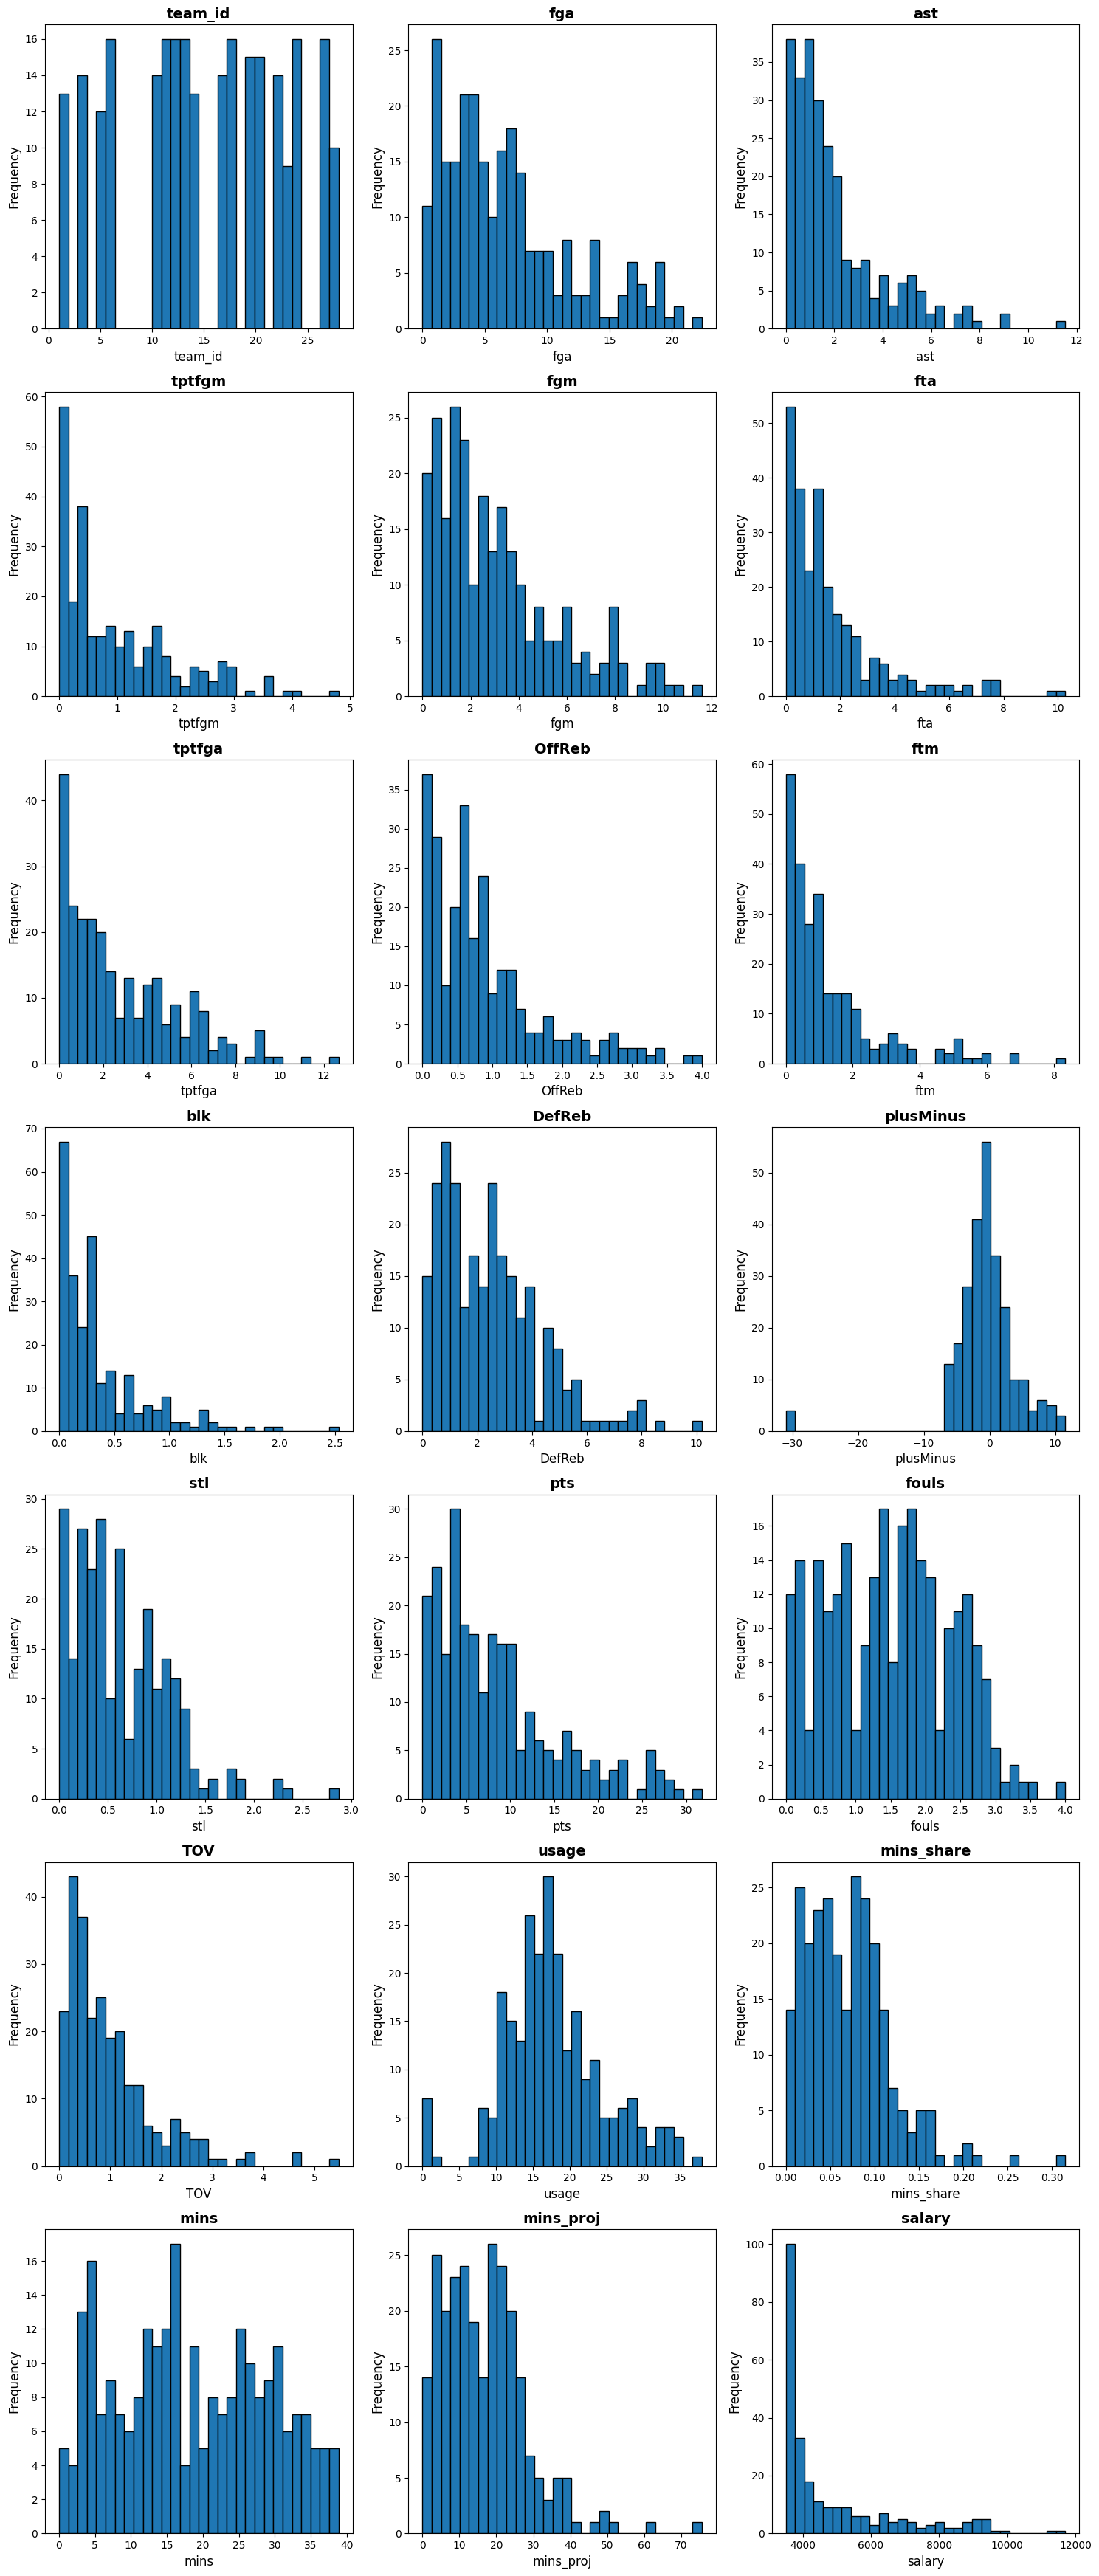

In [310]:
num_features = main_df.select_dtypes(include=['number']).columns
num_cols = 3  # Number of columns in the grid
num_rows = -(-len(num_features) // num_cols)  # Ceiling division to get the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figure size dynamically
axes = axes.flatten()  # Flatten the 2D array of subplots for easy indexing

for idx, col_name in enumerate(num_features):
    ax = axes[idx]  # Select the appropriate subplot
    ax.hist(main_df[col_name].dropna(), bins=30, edgecolor='black')

    # Set title and labels with larger font sizes
    ax.set_title(f"{col_name}", fontsize=14, fontweight='bold')
    ax.set_xlabel(col_name, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)

# Hide any unused subplots (in case total features are not a multiple of `num_cols`)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [311]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Brook Lopez,20250304_MIL@ATL,28006619932,17,MIL,ATL,10.533333,2.000000,1.733333,5.000000,...,30.866667,22.977667,6100,2025-03-04,C,False,False,False,False,True
2,Shake Milton,20250304_NO@LAL,28008397499,14,LAL,ORL,2.266667,1.333333,0.266667,1.066667,...,10.200000,46.362059,3600,2025-03-04,SG,True,False,False,False,False
3,Lonnie Walker,20250304_PHI@MIN,28018646789,23,PHI,HOU,6.933333,1.133333,0.933333,2.266667,...,16.000000,21.009473,3900,2025-03-04,SG,False,False,True,False,False
4,Steven Adams,20250304_HOU@IND,28018735349,11,HOU,TOR,4.466667,1.333333,0.000000,2.000000,...,15.733333,11.903672,4200,2025-03-04,C,False,False,False,False,True
5,Alex Reese,20250304_PHI@MIN,28018882869,23,PHI,TOR,1.000000,0.000000,0.000000,1.000000,...,2.000000,1.284338,3500,2025-03-04,PF,False,False,False,True,False


In [312]:
mins_proj_df = main_df.sort_values(by=['mins_proj', 'salary'], ascending=[False, True])


In [313]:
mins_proj_df

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
314,RJ Barrett,20250304_TOR@ORL,94994422047,28,TOR,MEM,15.133333,4.933333,2.000000,7.733333,...,32.333333,75.583730,7500,2025-03-04,SF,False,False,True,True,False
267,Coby White,20250304_CLE@CHI,94704402047,5,CHI,CHA,14.333333,3.933333,2.800000,5.933333,...,32.533333,61.536837,7000,2025-03-04,PG,True,True,False,False,False
115,Kelly Oubre,20250304_PHI@MIN,28628119129,23,PHI,CLE,13.866667,1.866667,1.133333,6.800000,...,38.866667,51.035511,6900,2025-03-04,SG,False,True,True,False,False
120,Precious Achiuwa,20250304_GS@NY,28678802027,20,NY,MIA,7.466667,1.200000,0.266667,4.000000,...,27.533333,49.073271,4400,2025-03-04,PF,False,False,False,True,True
149,Naz Reid,20250304_PHI@MIN,28858866027,18,MIN,CHI,15.800000,3.466667,2.733333,6.666667,...,35.333333,47.905179,8000,2025-03-04,C,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,Tony Bradley,20250304_HOU@IND,28128676399,12,IND,MIN,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.001148,3500,2025-03-04,C,False,False,False,False,True
177,Jahmir Young,20250304_CLE@CHI,94074499027,5,CHI,NO,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3500,2025-03-04,PG,True,False,False,False,False
232,Taran Armstrong,20250304_GS@NY,944249335539,10,GS,GS,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3500,2025-03-04,PG,False,True,False,False,False
234,Kevin McCullar,20250304_GS@NY,94444269647,20,NY,CLE,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3500,2025-03-04,SG,False,False,True,False,False


In [314]:
#Writing to csv
ready_for_pred = main_df

In [315]:
###PREDICTIONS

In [316]:
# Loss functions

RMSE_FD = 9.683
RMSE_DK = 9.668

#pos_cols = []

In [317]:
if site == 'FD': 
    model_path = "../../best_XGB_FD.pkl"
    scaler_path = "../../nba_scaler_fd.pkl"
    rmse = RMSE_FD
    #pos_cols = ["PG", "SG", "SF", "PF", "C"]
else:
    model_path = "../../best_XGB_DK.pkl"
    scaler_path = "../../nba_scaler_dk.pkl"
    rmse = RMSE_DK
    #pos_cols = ["PG", "SG", "SF", "PF", "C", "G", "F", "UTIL"]

# Load model and scaler
with open(model_path, "rb") as model_file, open(scaler_path, "rb") as scaler_file:
    model = pickle.load(model_file)
    scaler = pickle.load(scaler_file)
    
# Rename for model compatibility
ready_for_pred = ready_for_pred.rename(columns={'PF': 'PF_pos'})
X = ready_for_pred.rename(columns={'fouls': 'PF'})  # Rename fouls to PF because in the api 'personal fouls' is PF

# Select features and scale
expected_feature_order = [
    'fga', 'ast', 'tptfgm', 'fgm', 'fta', 'tptfga', 'OffReb', 'ftm', 'blk',
    'DefReb', 'plusMinus', 'stl', 'pts', 'PF', 'TOV', 'usage', 'mins_share',
    'mins', 'mins_proj'
]
        
X = X[expected_feature_order]
X_scaled = scaler.transform(X)

# Predict with the XGBoost model
predictions = model.predict(X_scaled)

# Store predictions
ready_for_pred[site + "_Pred"] = predictions
ready_for_pred[site + "_Floor"] = predictions - rmse
ready_for_pred[site + "_Ceiling"] = predictions + rmse
ready_for_pred[site + "_Value"] = (ready_for_pred[site + '_Pred']/ready_for_pred['salary']) * 1000

# Restore PF position column
ready_for_pred = ready_for_pred.rename(columns={'PF_pos': 'PF'})


#         # Store predictions in session state
#         # st.session_state["main_df_sorted"] = main_df_sorted
#         # ✅ Calculate "Value" column
#         st.session_state["main_df"]["Value"] = (st.session_state["main_df"]["Pred"] / 
#                                                        st.session_state["main_df"]["salary"]) * 1000
#         st.success("Predictions generated!")

In [318]:
pred_df = ready_for_pred.drop(columns = ['teamAbv', 'date', 'prim_pos'])

In [319]:
pred_df.to_csv(site + 'predictions.csv', index = False)

In [139]:
# Define database file path
db_path = "../nba_dfs_model.db"

# Ensure expected columns exist in main_df
expected_cols = [
    "longName", "game_id", "player_id", "team_id", "team",
    "fga", "ast", "tptfgm", "fgm", "fta", "tptfga", "OffReb", "ftm", "blk",
    "DefReb", "plusMinus", "stl", "pts", "fouls", "TOV", "usage",
    "mins_share", "mins", "mins_proj", "salary", "PG", "SG", "SF", "PF", "C", 
    "G", "F", "UTIL", "FD_Pred", "FD_Floor", "FD_Ceiling", "FD_Value",
    "DK_Pred", "DK_Floor", "DK_Ceiling", "DK_Value"
]

# Add any missing columns
for col in expected_cols:
    if col not in pred_df.columns:
        pred_df[col] = None

# Convert to match database types
pred_df = pred_df.astype({
    "salary": "Int64",
    "PG": "Int64", "SG": "Int64", "SF": "Int64", "PF": "Int64", "C": "Int64",
    "G": "Int64", "F": "Int64", "UTIL": "Int64"
})

# Append predictions to database
with sqlite3.connect(db_path) as conn:
    try:
        pred_df.to_sql("predictions", conn, if_exists="append", index=False)
        conn.commit()  # Ensure write is committed
        print("✅ Predictions successfully written!")

        # Check if rows were actually written
        cursor = conn.cursor()
        cursor.execute("SELECT COUNT(*) FROM predictions;")
        count = cursor.fetchone()[0]
        print(f"✅ Total rows in predictions table after insert: {count}")

    except Exception as e:
        print(f"❌ ERROR while writing to database: {e}")


✅ Predictions successfully written!
✅ Total rows in predictions table after insert: 3893


In [ ]:
#This is the CSV downloaded from the site
# site_df = pd.read_csv(f"{site}_Template_{today}.csv")